In [8]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [9]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()



In [10]:
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [11]:
# Save the input and target variables

print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

print('\n',data.shape, targets.shape)

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])

 (442, 10) (442,)


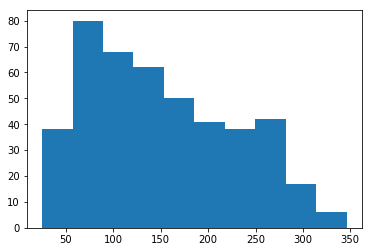

In [12]:
# Normalise the target data (this will make clearer training curves)
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(targets)
plt.show()


In [13]:
targets = (targets - targets.mean())/ targets.std()

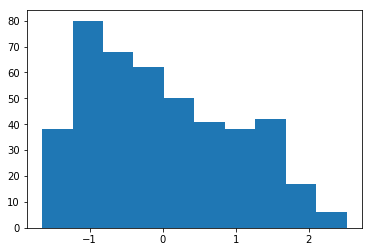

In [14]:
plt.hist(targets)
plt.show()

In [15]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)

(397, 10)
(397,)
(45, 10)
(45,)


#### Train a feedforward neural network model

In [81]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128,activation="relu",input_shape = (train_data.shape[1],)),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(1)
    ])
    return model


In [44]:
# Print the model summary
input_shape = (train_data.shape[1],)
print(input_shape)
model = get_model(input_shape)
model.summary()


(10,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_85 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_86 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_87 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_88 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_89 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_90 (Dense)             (None, 1)         

In [45]:
# Compile the model
model.compile(optimizer = "adam",loss = "mse",metric = ['mae'])


In [46]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data,train_targets, epochs = 100, validation_split= 0.15,batch_size = 64,verbose = 2)


Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 - 1s - loss: 1.0459 - val_loss: 0.7936
Epoch 2/100
337/337 - 0s - loss: 0.9754 - val_loss: 0.6692
Epoch 3/100
337/337 - 0s - loss: 0.8077 - val_loss: 0.4222
Epoch 4/100
337/337 - 0s - loss: 0.6070 - val_loss: 0.3853
Epoch 5/100
337/337 - 0s - loss: 0.5436 - val_loss: 0.3829
Epoch 6/100
337/337 - 0s - loss: 0.5106 - val_loss: 0.3603
Epoch 7/100
337/337 - 0s - loss: 0.4925 - val_loss: 0.3729
Epoch 8/100
337/337 - 0s - loss: 0.4911 - val_loss: 0.3790
Epoch 9/100
337/337 - 0s - loss: 0.4739 - val_loss: 0.4010
Epoch 10/100
337/337 - 0s - loss: 0.5155 - val_loss: 0.3794
Epoch 11/100
337/337 - 0s - loss: 0.4902 - val_loss: 0.3668
Epoch 12/100
337/337 - 0s - loss: 0.4550 - val_loss: 0.3709
Epoch 13/100
337/337 - 0s - loss: 0.4665 - val_loss: 0.3798
Epoch 14/100
337/337 - 0s - loss: 0.4604 - val_loss: 0.3787
Epoch 15/100
337/337 - 0s - loss: 0.4392 - val_loss: 0.3994
Epoch 16/100
337/337 - 0s - loss: 0.4394 - val_loss: 0.3712
Epoc

In [47]:
# Evaluate the model on the test set
model.evaluate(test_data,test_targets,verbose = 2)


45/1 - 0s - loss: 0.6269


0.7897362695799933

#### Plot the learning curves

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

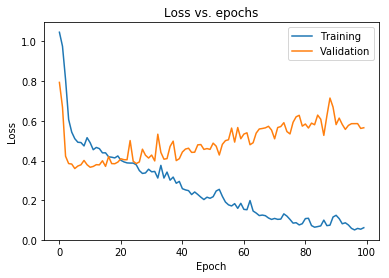

In [49]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Softmax
from tensorflow.keras import regularizers

In [35]:
def get_regularized_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", kernel_initializer=regularizers.l2(wd), input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_initializer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_initializer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_initializer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_initializer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(128, activation="relu", kernel_initializer=regularizers.l2(wd)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [48]:
def get_regularized_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [50]:
# Re-build the model with weight decay and dropout layers
model = get_regularized_model(1e-5,0.1)


In [53]:
# Compile the model
model.compile(optimizer = "adam",loss = "mse",metric = ['accuracy','mae'])

In [54]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data,train_targets,validation_split = 0.2,epochs = 5,verbose = 2)


Train on 317 samples, validate on 80 samples
Epoch 1/5
317/317 - 2s - loss: 0.4767 - val_loss: 0.6424
Epoch 2/5
317/317 - 0s - loss: 0.4377 - val_loss: 0.6371
Epoch 3/5
317/317 - 0s - loss: 0.4728 - val_loss: 0.6707
Epoch 4/5
317/317 - 0s - loss: 0.4369 - val_loss: 0.6285
Epoch 5/5
317/317 - 0s - loss: 0.4155 - val_loss: 0.6868


In [73]:
# Evaluate the model on the test set

(train_data.shape[1],)

(10,)

#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [70]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
    
    def on_train_begin(self, logs = None):
        print('starting training...')
        
    def on_epoch_begin(self, epoch, logs = None):
        print(f"training: starting epoch #{epoch}")
        
    def on_train_batch_begin(self, batch, logs = None):
        print(f"training: starting batch #{batch}")
    
    def on_train_batch_end(sefl, batch, logs = None):
        print(f"training: finished batch #{batch}")

    def on_epoch_end(self, epoch, logs = None):
        print(f"training: finished epoch #{epoch}")
        
    def on_train_end(self, logs = None):
        print('Finished Training!!')

        
class TestingCallback(Callback):
    
    def on_test_begin(self, logs = None):
        print('starting testing...')
        
    def on_test_batch_begin(self, batch, logs = None):
        print(f"testing: starting batch #{batch}")
    
    def on_test_batch_end(sefl, batch, logs = None):
        print(f"testing: finished batch #{batch}")
        
    def on_test_end(self, logs = None):
        print('Finished testing!!')
        
class PredictCallback(Callback):
    
    def on_predict_begin(self, logs = None):
        print('starting predict...')
        
    def on_predict_batch_begin(self, batch, logs = None):
        print(f"predict: starting batch #{batch}")
    
    def on_predict_batch_end(sefl, batch, logs = None):
        print(f"predict: finished batch #{batch}")
        
    def on_predict_end(self, logs = None):
        print('Finished predict!!')        
        

In [71]:
# Re-build the model

model = get_regularized_model(1e-5,0.3)


In [72]:
# Compile the model
model.compile(optimizer = 'adam',loss = 'mse')


#### Train the model with the callback

In [73]:
# Train the model, with some of the data reserved for validation
model.fit(train_data,train_targets,epochs = 3, batch_size = 128, callbacks = [TrainingCallback()])


Train on 397 samples
starting training...
training: starting epoch #0
Epoch 1/3
training: starting batch #0
training: finished batch #0
128/397 [========>.....................] - ETA: 2s - loss: 1.1020training: starting batch #1
training: finished batch #1
256/397 [==================>...........] - ETA: 0s - loss: 0.9663training: starting batch #2
training: finished batch #2
training: starting batch #3
training: finished batch #3
training: finished epoch #0
397/397 [==============================] - 1s 4ms/sample - loss: 0.9707
training: starting epoch #1
Epoch 2/3
training: starting batch #0
training: finished batch #0
128/397 [========>.....................] - ETA: 0s - loss: 0.8745training: starting batch #1
training: finished batch #1
training: starting batch #2
training: finished batch #2
training: starting batch #3
training: finished batch #3
training: finished epoch #1
397/397 [==============================] - 0s 254us/sample - loss: 0.9542
training: starting epoch #2
Epoch 3/3

In [74]:
# Evaluate the model
model.evaluate(test_data,test_targets,callbacks=[TestingCallback()],verbose = False)


starting testing...
testing: starting batch #0
testing: finished batch #0
testing: starting batch #1
testing: finished batch #1
Finished testing!!


1.046572616365221

In [75]:
# Make predictions with the model
model.predict(test_data,verbose = False,callbacks=[PredictCallback()])


starting predict...
predict: starting batch #0
predict: finished batch #0
predict: starting batch #1
predict: finished batch #1
Finished predict!!


array([[-0.14119306],
       [ 0.03082674],
       [ 0.09293195],
       [-0.15196426],
       [-0.098998  ],
       [ 0.11920231],
       [-0.00855723],
       [ 0.10234632],
       [ 0.04485414],
       [ 0.00816615],
       [ 0.10623073],
       [-0.07873701],
       [ 0.07539482],
       [-0.17573729],
       [-0.06428879],
       [-0.12579137],
       [-0.08667483],
       [-0.1882415 ],
       [-0.1758638 ],
       [-0.17710815],
       [ 0.09557238],
       [ 0.03051125],
       [-0.16476753],
       [-0.07047427],
       [-0.1897244 ],
       [ 0.10448547],
       [-0.08530673],
       [ 0.11606953],
       [-0.12488779],
       [ 0.12215302],
       [-0.11727555],
       [ 0.10672197],
       [-0.11668836],
       [-0.18132848],
       [-0.02153977],
       [-0.04335453],
       [ 0.12299971],
       [-0.1806118 ],
       [-0.15403691],
       [-0.13412125],
       [-0.04440739],
       [ 0.06870127],
       [-0.17396715],
       [-0.15665178],
       [-0.15523313]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [94]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer = 'adam', loss = 'mse')
unreg_history = unregularised_model.fit(train_data,train_targets, epochs = 100,
                                       validation_split = 0.15, batch_size = 64,
                                       verbose = False, callbacks = 
                                       [tf.keras.callbacks.EarlyStopping(patience = 10)])

In [83]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data,test_targets,verbose=2)


45/1 - 0s - loss: 0.4909


0.5589715705977546

In [97]:
# Re-train the regularised model
regularized_model = get_regularized_model(1e-8,0.2)
regularized_model.compile(optimizer = 'adam', loss = 'mse')
reg_history = regularized_model.fit(train_data,train_targets,epochs = 100,
                                       validation_split = 0.15, batch_size = 64,
                                       verbose = False, callbacks = 
                                       [tf.keras.callbacks.EarlyStopping(patience = 10)])

In [98]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data,test_targets, verbose = 2)


45/1 - 0s - loss: 0.3010


0.4717845171689987

In [99]:
reg_history.history['val_loss']

[0.9387915134429932,
 0.8736163973808289,
 0.7552022337913513,
 0.6313043832778931,
 0.6463908553123474,
 0.6968931555747986,
 0.6761332750320435,
 0.689166784286499,
 0.6902228593826294,
 0.6839618682861328,
 0.6925480961799622,
 0.6827444434165955,
 0.7281116247177124,
 0.6895678043365479]

#### Plot the learning curves

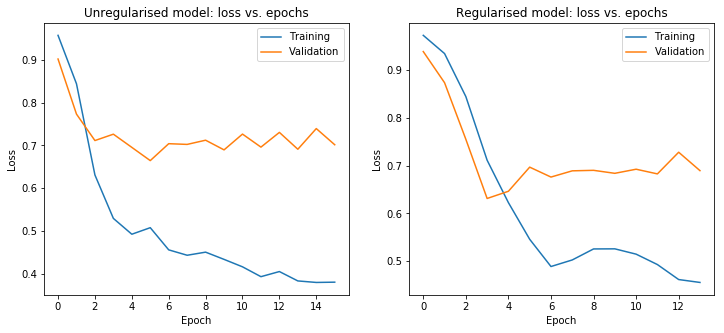

In [100]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()